# MNIST Demo

Demonstration of py-holmes in --dl mode on samples from the [MNIST handwritten digit database](http://yann.lecun.com/exdb/mnist/).

Heavliy borrows from [this tutorial on Medium](https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118).

### WARNING: Before running this notebook, decide whether you want to train a new model or load an existing one.  Based on your choice, either skip the part that loads a model, or skip the part that sets hyperparameters and trains a new one.

## Apply a random seed for reproducibility

In [1]:
import random
import torch
import numpy as np

def seed_all(s):
    random.seed(s)
    torch.manual_seed(s)
    np.random.seed(s)
    
chosen_seed = 0
seed_all(chosen_seed)

## Define model architecture, loss function, optimizer, hyperparameters

In [2]:
import dnn_mnist_1 as model_definition  # This predefines an architecture, loss function, optimizer, and hyperparameters.
                                        # It also loads such a model that we've already trained.

model = model_definition.model
loss_func = model_definition.loss_func
optimizer = model_definition.optimizer
EPOCHS = model_definition.EPOCHS
LR = model_definition.LR
EPS = model_definition.EPS
BATCH_SIZE = model_definition.BATCH_SIZE

cuda:0
cuda device 0 is NVIDIA GeForce RTX 3080 Laptop GPU
Net(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)


## Assemble the MNIST dataset and dataloaders

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_and_val_datasets = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_dataset = datasets.MNIST(
               root = 'data', 
               train = False, 
               transform = ToTensor()
)


# Split the training data into a training set and a validation set
validation_split = 0.11
shuffle_dataset = True
dataset_size = (len(train_and_val_datasets))
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

# Create loaders for all 3 datasets
train_loader = torch.utils.data.DataLoader(train_and_val_datasets, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_and_val_datasets, batch_size=BATCH_SIZE, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

## Select device

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(f"cuda device 0 is {torch.cuda.get_device_name(0)}")

cuda:0
cuda device 0 is NVIDIA GeForce RTX 3080 Laptop GPU


## Show some example inputs from the dataset, along with their labels

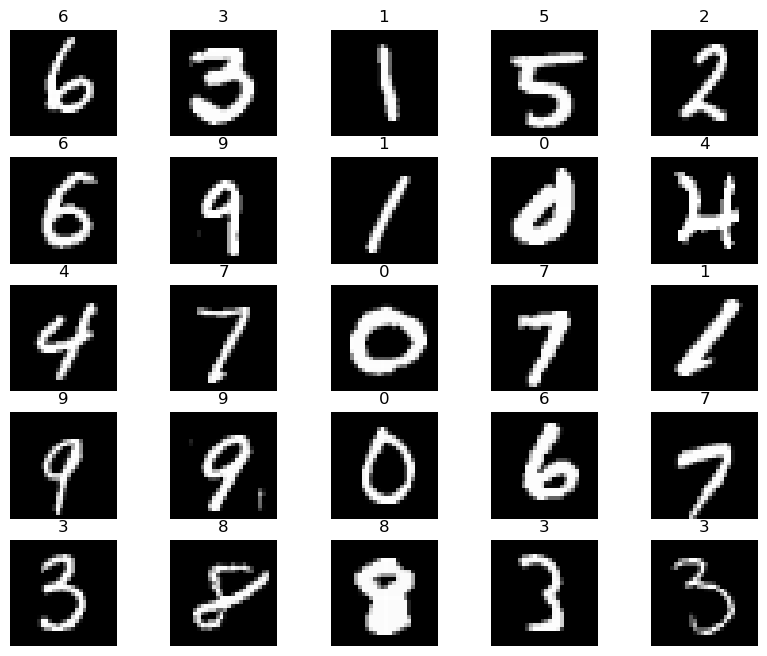

In [5]:
from matplotlib import pyplot as plt

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_and_val_datasets), size=(1,)).item()
    img, label = train_and_val_datasets[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Define validation

In [6]:
def get_validation_performance(provide_failures=False):
    # Put the model into evaluation mode
    model.eval()
    
    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    
    total_correct = 0
    
    if provide_failures:
        failures = []
    
    num_val_samples = 60000 - 53400
    for sample_index in range(53400, 60000):
        x = train_and_val_datasets.data[sample_index]
        label = torch.Tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
        label[0, train_and_val_datasets.targets[sample_index].item()] = 1

        x, label = x.to(device), label.to(device)
        x = x.to(torch.float32)     # Because the model expects float32
        
        # Tell PyTorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed while training (for backpropagation).
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            output = model(x)
            loss = loss_func(output, label)
            
            # Accumulate the validation loss
            total_eval_loss += loss.item()
            
            # Calculate the number of correctly labeled examples in batch
            class_guess = torch.argmax(output, dim=1)
            total_correct += class_guess.item() == torch.argmax(label).item()
            
            # If asked to, provide failures
            if provide_failures:
                if class_guess.item() != label.argmax().item():
                    sample = x.detach().cpu().numpy()
                    guessed = class_guess.item()
                    actual = label.argmax().item()
                    failures.append([sample, guessed, actual])
    
    # Report the final accuracy for this validation run
    print(f"Num of correct predictions = {total_correct}")
    avg_val_accuracy = total_correct / num_val_samples
    
    if provide_failures:
        return avg_val_accuracy, failures
    else:
        return avg_val_accuracy

## Train a model

In [7]:
"""
import torch.nn as nn
from torch import optim
from datetime import datetime


# SET HYPERPARAMETERS
EPOCHS = 50
LR = 0.001
EPS = 1e-8
BATCH_SIZE = 100

# Instantiate the model
model = model_definition.Net().to(device)
print(model)

# Define a loss function
loss_func = nn.CrossEntropyLoss()

# Define an optimizer
optimizer = optim.Adam(model.parameters(), lr=LR, eps=EPS)
print(optimizer)

# Train (heavily borrows from this tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
best_val_acc = -float("inf")
for epoch_i in range(EPOCHS):
    print(f"Beginning epoch {epoch_i+1}")
    model.train()    # Put the model into training mode
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Load images and labels
        inputs, labels = data
        # Move them to the GPU if available
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward, backward, optimize
        logits = model(inputs)
        loss = loss_func(logits, labels)
        loss.backward()
        optimizer.step()
        
        # Print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set. Implement this function in the cell above.
    print(f"Total training loss: {running_loss}")
    val_acc = get_validation_performance()
    print(f"Validation accuracy: {val_acc}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        # Save the model in its current state
        savename = f"ph_models/mnist/modeldate{str(datetime.now()).replace(':', '_').replace(' ', ',')}_bs{BATCH_SIZE}_lr{LR}_eps{EPS}_epochs{epoch_i+1}_valacc{round(val_acc, 4)}.pth"
        torch.save(model.state_dict(), savename)
        print(f"NEW BEST!  Saved model after epoch {epoch_i+1}")
    print("")
    
print("")
print("Training complete!")
"""

'\nimport torch.nn as nn\nfrom torch import optim\nfrom datetime import datetime\n\n\n# SET HYPERPARAMETERS\nEPOCHS = 50\nLR = 0.001\nEPS = 1e-8\nBATCH_SIZE = 100\n\n# Instantiate the model\nmodel = model_definition.Net().to(device)\nprint(model)\n\n# Define a loss function\nloss_func = nn.CrossEntropyLoss()\n\n# Define an optimizer\noptimizer = optim.Adam(model.parameters(), lr=LR, eps=EPS)\nprint(optimizer)\n\n# Train (heavily borrows from this tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)\nbest_val_acc = -float("inf")\nfor epoch_i in range(EPOCHS):\n    print(f"Beginning epoch {epoch_i+1}")\n    model.train()    # Put the model into training mode\n    running_loss = 0.0\n    for i, data in enumerate(train_loader, 0):\n        # Load images and labels\n        inputs, labels = data\n        # Move them to the GPU if available\n        inputs, labels = inputs.to(device), labels.to(device)\n        # Zero the parameter gradients\n        optimizer.zero_g

## Get the accuracy of the model, and the subset of val images on which the model fails

In [8]:
avg_val_acc, failures = get_validation_performance(provide_failures=True)
print(f"Average val accuracy: {avg_val_acc}")

Num of correct predictions = 6568
Average val accuracy: 0.9951515151515151


## For each of those failing images, show nearby passing images recommended by py-holmes

Define a class that will help us get parse inputs as torch tensors from log files.

In [9]:
import os
from colorama import Fore, Style
from ph_basic_processing.stripping import strip_custom


class PassingTestResult:
    def __init__(self, text: str):
        """
        :param text: not including the "...///... PASSING TEST ...///..." of this test
        """
        self.text = text
        self.new_input = self.get_new_input()
    
    def get_new_input(self) -> torch.Tensor:
        """Return the new input that elicited the passing test."""
        # Get the sequence of elements
        index_start = self.text.index("tensor([[") + 9
        index_end = self.text.index("]],")
        text_combined = self.text[index_start:index_end]        
        text_combined = text_combined.replace("\n", "")
        text_combined = text_combined.replace(" ", "")
        text_combined = text_combined.replace("[", "")
        text_combined = text_combined.replace("]", "")

        # Return as a tensor
        tensor_elements = text_combined.split(",")
        tensor_elements = [float(el) for el in tensor_elements]
        assert(28*28 == len(tensor_elements))
        tensor_elements_2d = []
        for ii in range(28):
            tensor_elements_2d.append(tensor_elements[28*ii:28*(ii+1)])
        return torch.FloatTensor(tensor_elements_2d)

Define a simple function to help us write the labels in `unittest`-style unit tests.

In [10]:
def label_int_to_tensor_string(label: int) -> str:
    """Given a label in the range 0 through 9 inclusive, return a string of Python code
    for the tensor representation of that string.  For example, 0 would become
    torch.Tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
    """
    elements = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    elements[label] = 1
    out = f"torch.Tensor([{elements}])"
    return out

For each failing example, automatically generate a `unittest`-style unit test, then call py-holmes on it and visualize the most similar passing inputs it finds.


--------------------------------------------------------------------------------


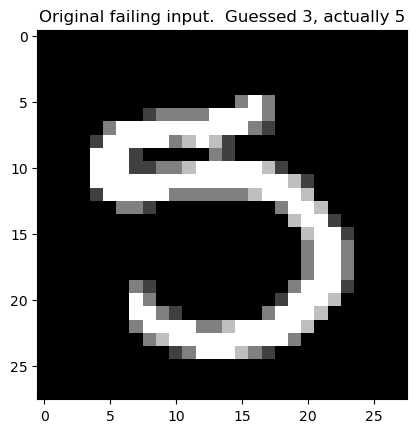

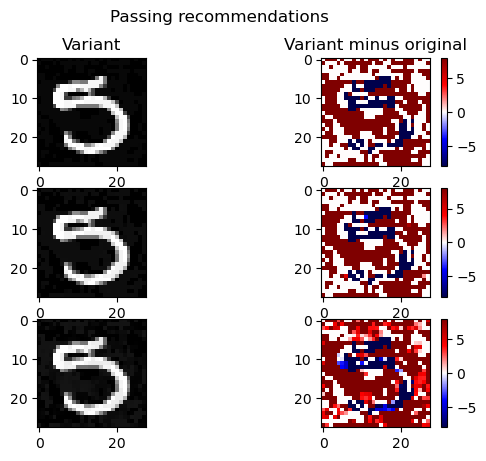


--------------------------------------------------------------------------------


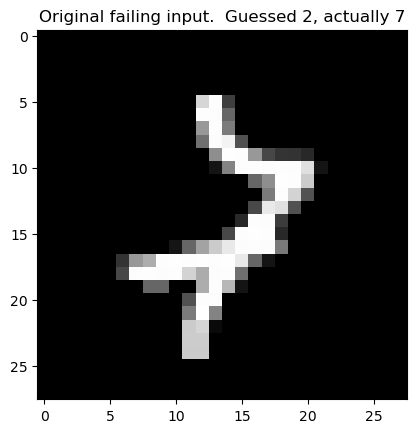

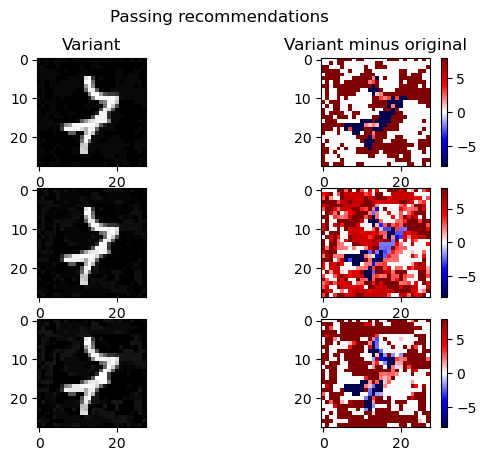


--------------------------------------------------------------------------------


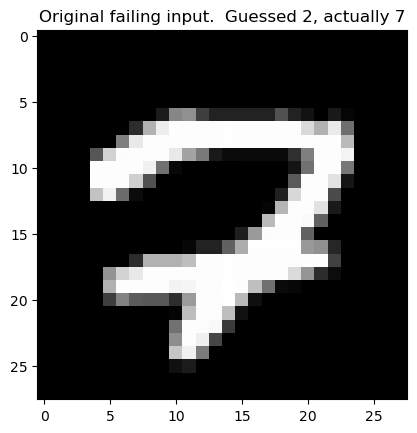

Py-holmes found no passing variants for this input.

--------------------------------------------------------------------------------


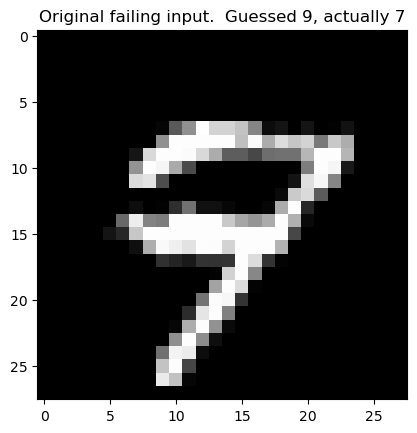

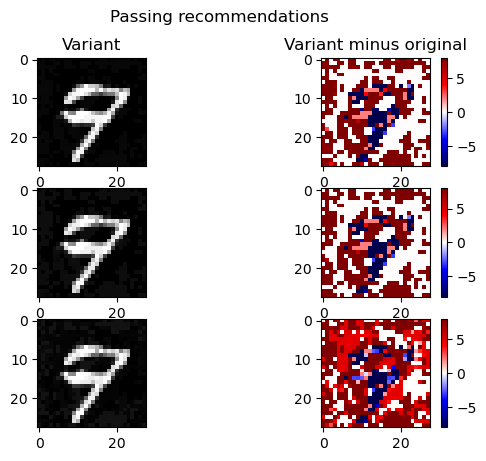


--------------------------------------------------------------------------------


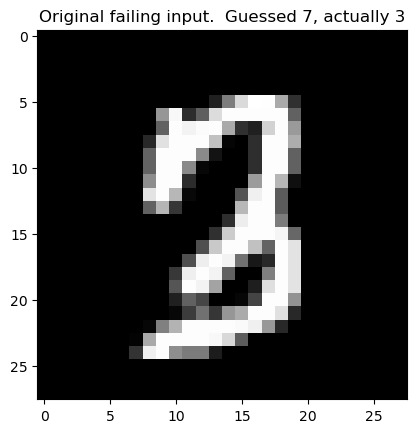

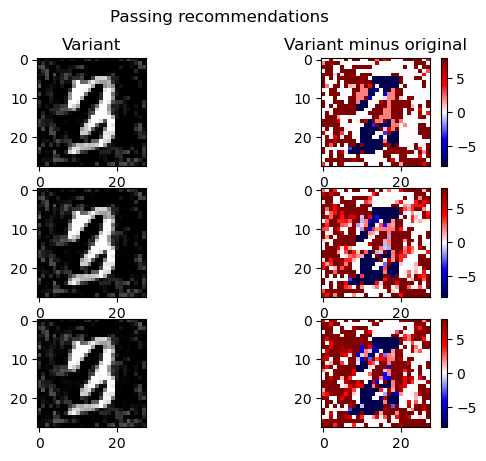


--------------------------------------------------------------------------------


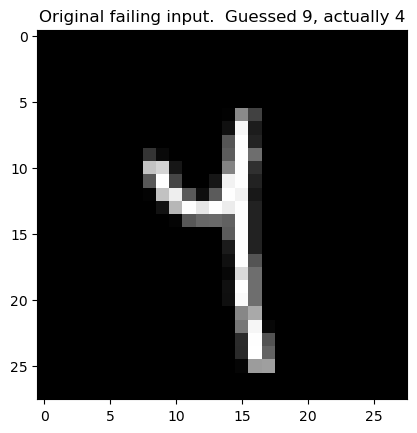

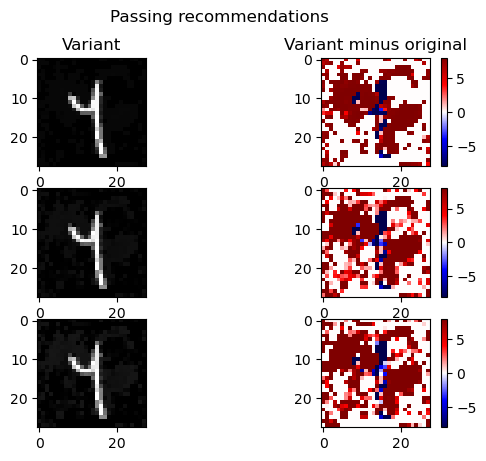

In [11]:
import matplotlib.colors as colors


diff_norm = colors.TwoSlopeNorm(vcenter=0)


cases_to_show = 5    # Number of cases to show py-holmes' passing suggestions on.  Cases where none of py-holmes' suggestions pass do not count toward this limit.
passing_test_announcer = f"{Fore.GREEN}//////////////////////// PASSING TEST ////////////////////////{Style.RESET_ALL}\n"
failing_test_announcer = f"{Fore.RED}//////////////////////// FAILING TEST ////////////////////////{Style.RESET_ALL}\n"

# For each failed image...
cases_shown_counter = 0
for failing_input, guessed, actual in failures:
    if cases_shown_counter >= cases_to_show:
        break

    # Make a little divider
    print()
    print("-"*80)
    
    # Visualize the image
    plt.imshow(failing_input, cmap="gray")
    plt.title(f"Original failing input.  Guessed {guessed}, actually {actual}")
    plt.show()
    
    # Create a unittest version of this failing input
    with open("test_one_failed_mnist_input.py", "w", encoding="utf-8") as file:
        to_write = []
        to_write.append(f'''"""File automatically generated by mnist_demo.ipynb"""''')
        to_write.append(f"")
        to_write.append(f"")
        to_write.append(f"import unittest")
        to_write.append(f"import dnn_mnist_1 as model_definition")
        to_write.append(f"import torch")
        to_write.append(f"import torch.nn as nn")
        to_write.append(f"from torch import optim")
        to_write.append(f"")
        to_write.append(f"")
        to_write.append(f"class TestFailedInput(unittest.TestCase):")
        to_write.append(f"    def test_0(self):")
        to_write.append(f'        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")')
        to_write.append(f"        model = model_definition.model")
        to_write.append(f"        model.cuda()")
        to_write.append(f"        optimizer = optim.Adam(model.parameters(), lr=0.001, eps=1e-8)")
        to_write.append(f"        loss_fn = nn.CrossEntropyLoss()")
        to_write.append(f"        xmin = 0")
        to_write.append(f"        xmax = 255")
        to_write.append(f"        adjustment_rate = 8")
        to_write.append(f"        indices_to_protect_from_fuzzing = []")
        to_write.append(f"        label = {label_int_to_tensor_string(actual)}.to(device)")
        to_write.append(f"        x = torch.Tensor([")
        for rr in range(np.shape(failing_input)[0]):
            this_row_string = "["
            for cc in range(np.shape(failing_input)[1]):
                this_row_string += f"{failing_input[rr, cc]}, "
            this_row_string += "]"
            to_write.append(f"                          {this_row_string},")
        to_write.append(f"        ]).to(device)")
        to_write.append(f"        output = model(x)")
        to_write.append(f"        guess = torch.argmax(output)")
        to_write.append(f"        self.assertEqual({actual}, guess.item())")
        for line in to_write:
            file.write(line + "\n")
    
    # Run py-holmes on the failed image
    os.system(f"python py_holmes.py --dl -f test_one_failed_mnist_input.py -l 12 --seed 0 > single_report.txt")
    
    # Get passing inputs that py-holmes discovered
    with open("single_report.txt", "r", encoding="utf-8") as file:
        log_result = file.read()
    if passing_test_announcer not in log_result:
        print("Py-holmes found no passing variants for this input.")
        continue
    else:
        cases_shown_counter += 1
    log_result = log_result.split(passing_test_announcer)
    log_result = log_result[1:]
    log_result[-1] = log_result[-1].split(failing_test_announcer)[0]
    passing_test_results = [PassingTestResult(el) for el in log_result]
    passing_inputs = [el.new_input for el in passing_test_results]
    
    # Visualize the passing altered images suggested by py-holmes-dl
    if len(passing_inputs) == 1:
        fig, ((ax1, ax2)) = plt.subplots(1, 2)
    elif len(passing_inputs) == 2:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    elif len(passing_inputs) == 3:
        fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
    fig.suptitle(f"Passing recommendations")
    # Show the image itself for first row
    ax1.imshow(passing_inputs[0], cmap="gray")
    ax1.set_title(f"Variant")
    # Show a heatmap of changes for first row
    heatmap_for_ax2 = ax2.imshow(passing_inputs[0] - failing_input, cmap="seismic", norm=diff_norm)
    plt.colorbar(heatmap_for_ax2,ax=ax2)
    ax2.set_title("Variant minus original")
    # Other rows
    if len(passing_inputs) >= 2:
        ax3.imshow(passing_inputs[1], cmap="gray")
        heatmap_for_ax4 = ax4.imshow(passing_inputs[1] - failing_input, cmap="seismic", norm=diff_norm)
        plt.colorbar(heatmap_for_ax4,ax=ax4)
    if len(passing_inputs) >= 3:
        ax5.imshow(passing_inputs[2], cmap="gray")
        heatmap_for_ax6 = ax6.imshow(passing_inputs[2] - failing_input, cmap="seismic", norm=diff_norm)
        plt.colorbar(heatmap_for_ax6,ax=ax6)
    # Show
    plt.show()